#**LinkedIn Agent: A Guided Multi-Agent System for LinkedIn Automation**

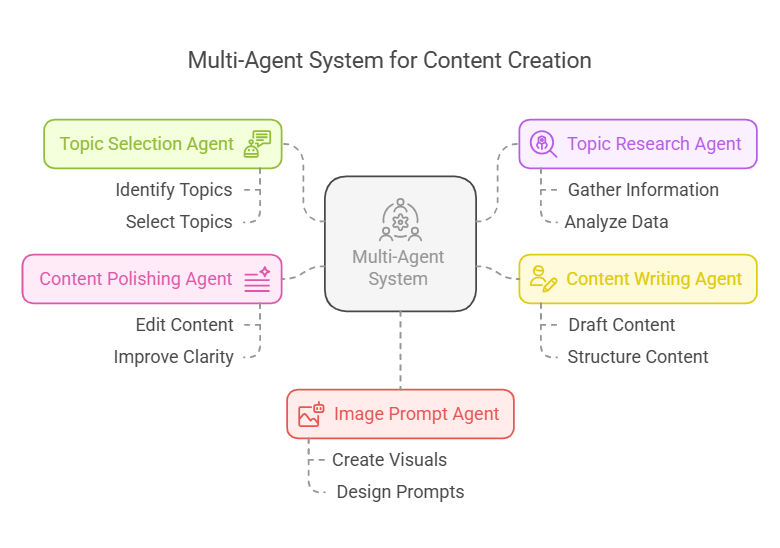

This guided notebook will walk you through building a LinkedIn automation system using CrewAI's multi-agent framework and Google's Gemini 1.5 Pro model. By the end of this tutorial, you'll have a working system that can perform LinkedIn Content Creation.

#### **Introduction to LinkedIn Agent**
LinkedIn Agent is a automation system that leverages multiple AI agents to perform complex tasks related to LinkedIn analysis, content creation, research, content writing, refining the content according to user style, generating image prompts, generating images and creating PDF. This project demonstrates how to orchestrate multiple specialized agents to work together toward common goals.

In this notebook, you'll learn how to:

* Set up a multi-agent system using CrewAI

* Connect to Google's Gemini 1.5 Pro model

* Implement web scraping for data

* Generate professional PDF for posting

* Create specialized agents for different LinkedIn tasks

Let's get started with this exciting project!

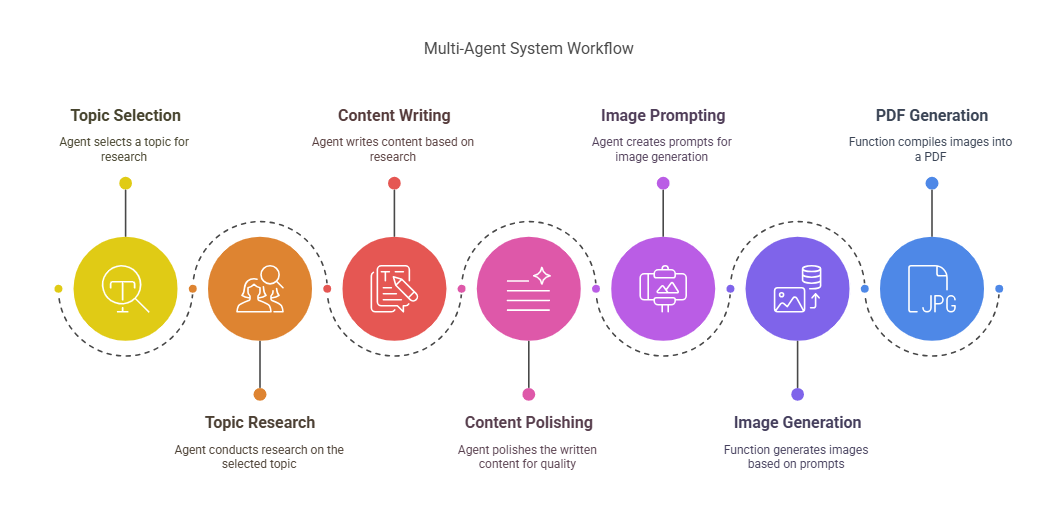

### **Section 1: Environment Setup**

This section handles the installation of required packages and ensures your environment is properly configured.

The key packages we're installing are:

* CrewAI : Framework for creating and orchestrating multiple AI agents

* CrewAI Tools : Pre-built tools for common tasks like web scraping and search

* LangChain Community : Provides components for building LLM applications

* ReportLab : PDF generation library with advanced formatting capabilities

* Requests : For making API calls

* Pillow : For image processing

In [ ]:
!pip install --upgrade -q crewai crewai_tools langchain_community reportlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.2/240.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.9/545.9 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.9 MB/s eta 0

Importing the necessary libraries for Project

In [ ]:
import IPython.display
from IPython.display import Markdown, HTML, display
import json
from crewai import LLM
from crewai import Agent, Task, Crew
from crewai_tools import SerperDevTool,ScrapeWebsiteTool
import re
import os
import requests
import time
from datetime import datetime
from PIL import Image
from typing import Union, List, Dict
from crewai.tools.base_tool import BaseTool
from reportlab.lib.pagesizes import landscape, inch
from reportlab.lib import colors
from reportlab.pdfgen import canvas
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.enums import TA_LEFT
from reportlab.platypus import Paragraph, Frame, Spacer
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
/usr/local/lib/python3.11/dist-packages/crewai_tools/tools/scrapegraph_scrape_tool/scrapegraph_scrape_tool.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_

### **Section 2: Styling and Display Configuration**

This section sets up custom CSS styling for a better notebook appearance and user experience.

In [ ]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### **Section 3: API Credentials**

In this section, we set up authentication to access Google's Vertex AI API for the Gemini 1.5 Pro model.

* Important Note:
You'll need to obtain your own Google Vertex AI credentials

**Steps to create Google Vertex AI credentials**

Step 1: Create a Service Account
* Go to Google Cloud Console → Google Cloud IAM & Admin
* Click "Create Service Account"
* Set a name (e.g., linkedin_project)
* Click Continue → Done

Step 2: Generate a Key File (JSON)
* Find the service account you created (linkedin_project)
* Click on it → Go to "Keys" tab
* Click "Add Key" → "Create New Key"
* Select JSON → Click Create
* A JSON file (e.g., linkedin_project_service_account.json) will be downloaded

Step 3: Use the Credentials in Your Code
* Place the downloaded JSON file in a secure location and load it

In [ ]:
file_path = 'path_to_your_file'

# Load the JSON file
with open(file_path, 'r') as file:
    vertex_credentials = json.load(file)

# Convert the credentials to a JSON string
vertex_credentials_json = json.dumps(vertex_credentials)

### **Section 4: Language Model Configuration**

This section initializes the Gemini 1.5 Pro model that will power our agents intelligence.

***Note : You can use any LLM of your choice***

**Steps to get Gemini API Key**

Step 1 : Go to [Gemini Website](https://ai.google.dev/gemini-api/docs/api-key)

Step 2 : Click on `Get a Gemini API key in Google AI Studio`

Step 3 : Click on `Create API Key` and select existing project or create one.

In [ ]:
llm = LLM(
    model="gemini/gemini-1.5-pro",
    temperature=0.8,
    api_key="YOUR_API_KEY",
    vertex_credentials=vertex_credentials_json
)

### **Section 5: Tool Setup**

This section sets up the specialized tools our agents will use to perform their tasks.

`Serper` : Used to search the Internet

`Clipdrop` : Used to generate Images

Get Your Serper API Key at [SERPER API KEY](https://serper.dev/api-key)

Get Your Clipdrop API Key at [CLIPDROP API KEY](https://clipdrop.co/apis/account)

In [ ]:
os.environ["SERPER_API_KEY"] = "SERPER_API_KEY"
os.environ["CLIPDROP_API_KEY"]="CLIPDROP_API_KEY"

In [ ]:
search_tool = SerperDevTool()

### **Section 6: Agent Definition**

This section defines the specialized agents that will work together in our system.

`Role` : Defines the agent’s function and expertise within the crew.

`Goal` : The individual objective that guides the agent’s decision-making.

`Backstory` :	Provides context and personality to the agent, enriching interactions.

`LLM` : Language model that powers the agent. Defaults to “gpt-4”.

`Tools` : Capabilities or functions available to the agent. Defaults to an empty list.

`Max Iterations` : Maximum iterations before the agent must provide its best answer. Default is 20.

`Allow Delegation` : Allow the agent to delegate tasks to other agents. Default is False.

*Note : Gemini API has limitation of 2 requests per minute and 50 requestes in a day*

Hence
`max_iter=1`

Agent 1 : To Find 5 topics around emerging AI trends

In [ ]:
topic_selection_agent = Agent(
    role="LinkedIn AI Content Strategist",
    goal="Identify, analyze, and curate emerging AI trends that resonate with tech professionals on LinkedIn,"
         "sparking engagement and thought leadership.",
    backstory="You are a seasoned AI trends expert and LinkedIn content strategist with a strong background in"
              "digital marketing and social media analytics. You specialize in detecting early AI trends and"
              "transforming them into compelling content tailored for a professional audience.Your insights"
              "consistently drive meaningful conversations, foster community growth, and position brands as"
              "industry thought leaders on LinkedIn.",
    verbose=True,
    allow_delegation=False,
    max_iter=1,
    tools=[search_tool],
    llm=llm
)


Agent 2 : To Research around selected topic

In [ ]:
topic_research_agent = Agent(
    role="LinkedIn AI Research Analyst",
    goal="Conduct comprehensive research on the selected AI topic by synthesizing insights from academic literature,"
         "expert opinions, and trending discussions, then delivering actionable and engaging content tailored for"
         "LinkedIn professionals.",
    backstory="You are a veteran AI research analyst with extensive experience bridging academic research and"
              "industry insights.You excel at navigating scholarly articles, white papers, and real-time expert"
              "commentary, distilling complex AI concepts into clear, compelling narratives that resonate with"
              "a professional LinkedIn audience.Known for your rigorous methodology and keen eye for emerging trends,"
              "you ensure that every analysis not only informs but also sparks meaningful conversations among tech"
              "professionals.",
    tools=[search_tool],
    llm=llm,
    max_iter=1,
    allow_delegation=False,
    verbose=True
)


Agent 3 : To Refine content to match the writing style of user

In [ ]:
content_writing_agent = Agent(
    role="LinkedIn Content Refinement Specialist",
    goal="Rewrite the research content to precisely match the provided "
          "writing style and tone, ensuring the final post is engaging "
          "and consistent with the sample style.",
    backstory="You are a specialist in content transformation, adept at "
               "analyzing and replicating distinctive writing styles. You have "
               "honed your skills by studying various successful LinkedIn posts "
               "and can effortlessly merge research insights with the precise "
               "tone, diction, and structure specified in the task. Your expertise "
               "ensures that the refined content not only conveys the necessary "
               "insights but also mirrors the provided style to maintain authenticity "
               "and engagement.",
    llm=llm,
    max_iter=1,
    verbose=True
)


Agent 4 : To polish the content for engagement

In [ ]:
content_polishing_agent = Agent(
    role="Writing Enhancement Specialist",
    goal="Polish the rewritten content to be engaging, humorous, "
          "and human-like while removing repetition.",
    backstory="You are a creative storyteller and content strategist. Your expertise "
               "lies in transforming AI-generated text into content that feels natural, "
               "engaging, and uniquely human. You infuse relatable humor, real-world analogies, "
               "and storytelling techniques to keep readers hooked.",
    llm=llm,
    max_iter=1,
    verbose=True
)


Agent 5 : To generate Image prompts and give call to Image Generation and PDF Generation function

In [ ]:
image_prompt_agent = Agent(
    role="AI Image Prompt Generator",
    goal="Generate creative and engaging image prompts for each page "
          "of the LinkedIn carousel.",
    backstory="You are an expert in visual storytelling. You analyze written content "
               "and generate descriptive image prompts that capture the essence of each page. "
               "Your prompts are designed to produce high-quality, black-and-white cartoon-style "
               "illustrations with exaggerated expressions, soft outlines, and simple yet engaging backgrounds.",
    llm=llm,
    max_iter=1,
    verbose=True
)


### **Section 7: Task and Function Definition**

This section defines the specific tasks our agents will perform.

`Description`	:	A clear, concise statement of what the task entails.

`Expected Output`	:	A detailed description of what the task’s completion looks like.

`Agent` : The agent responsible for executing the task.

`Context` : Other tasks whose outputs will be used as context for this task.

`Human Input` : Whether the task should have a human review the final answer of the agent. Defaults to False.

`Callback` : Function/object to be executed after task completion.

`topic_selection_callback` : Used to display list of 5 topics and asks user to select one topic for further research

In [ ]:
def topic_selection_callback(task_output):
    # Extract raw text from task output
    raw_text = task_output.raw

    # Split raw text into individual lines
    lines = raw_text.splitlines()
    topic_titles = []

    # Iterate over lines and extract headings from lines that start with a number and period
    for line in lines:
        line = line.strip()
        if re.match(r"^\d+\.\s*", line):
            # Remove the number and period
            clean_line = re.sub(r"^\d+\.\s*", "", line)
            # Split by the first colon to extract the heading
            parts = clean_line.split(":", 1)
            if parts:
                topic_titles.append(parts[0].strip())

    print("\nTrending AI Topics:")
    for idx, topic in enumerate(topic_titles, start=1):
        print(f"{idx}. {topic}")

    while True:
        try:
            choice = int(input("\nEnter the serial number of the topic you want to research further: "))
            if 1 <= choice <= len(topic_titles):
                selected_topic = topic_titles[choice - 1]
                print(f"\nYou selected: {selected_topic}")
                global topic_research_task
                topic_research_task.description = topic_research_task.description.format(topic=selected_topic)
                return selected_topic
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Please enter a valid number.")

In [ ]:
topic_selection_task = Task(
    description="Conduct a deep research to identify trending and engaging AI topics for "
                 "LinkedIn content. Your investigation should focus on current and emerging "
                 "AI developments that are likely to generate high engagement among professionals. "
                 "Specifically, explore the following areas: "
                 "1. Recent AI innovations and announcements within the last 3-6 months; "
                 "2. AI topics generating significant buzz on LinkedIn and Twitter; "
                 "3. Innovative AI applications in business settings; "
                 "4. AI ethical considerations and debates that resonate with professionals; "
                 "5. AI tools and resources being actively discussed in industry circles. "
                 "For each area, analyze multiple search results to identify recurring themes, "
                 "patterns, and specific developments that are timely and relevant.",
    expected_output="Provide a well-organized list of 5 potential topics. For each topic, include: "
                     "• A serial number; "
                     "• A clear, concise topic title; "
                     "Ensure the output is formatted as numbered items for easy review.",
    human_input=True,
    callback=topic_selection_callback,
    agent=topic_selection_agent
)


In [ ]:
topic_research_task = Task(
    description=
        "Conduct an in-depth research study on {topic} and compile a comprehensive, "
        "engaging LinkedIn post.\n\n"
        "### Research Guidelines:\n"
        "Explore research papers, expert discussions, and industry applications.\n"
        "Identify key insights, controversies, and expert opinions.\n"
        "Include relevant examples, statistics, and real-world impact.\n\n"
        "### Expected Output:\n"
        "- **Introduction:** Engaging start that hooks the reader.\n"
        "- **Key Insights:** What professionals need to know.\n"
        "- **Real-World Applications:** Where this AI trend is making an impact.\n"
        "- **Challenges & Debates:** Ethical, technical, and adoption challenges.\n"
        "- **Conclusion & Call to Action:** Thought-provoking takeaway.\n"
        "Ensure the post is at least **1000 words** long and highly engaging.",
    expected_output=
        "A structured, well-researched LinkedIn post of at least 1000 words. "
        "The post should be organized with clear headings, bullet points, "
        "and a compelling narrative that engages professionals.",
    context=[topic_selection_task],
    agent=topic_research_agent
)


In [ ]:
content_writing_task= Task(
    description=
        "Rewrite the research output to match the provided sample writing style.\n\n"
        "### Sample Writing Style:\n{style_sample}\n\n"
        "Your task is to produce an engaging and professional LinkedIn post that adheres "
        "to the tone, humor, and style exemplified in the sample."
        "Ensure the final content is cohesive, clear, and compelling for a professional audience.",
    expected_output=
        "A refined LinkedIn post that is engaging, professionally written, and closely "
        "aligns with the provided sample writing style. The output should be clear, polished, "
        "and ready for review.If needed use numbers instead of bullet points",
    human_input=True,
    context=[topic_research_task],
    agent=content_writing_agent
)


`polished_output_to_json` : Parses raw text input into a structured JSON format.

In [ ]:
def polished_output_to_json(polished_output):
    # Extract raw text and force it to a string
    raw_text = str(polished_output.raw).strip()
    print("Raw polished output:\n", raw_text)

    # Process line by line
    lines = raw_text.split('\n')

    results = []
    current_page = None
    current_heading = ""
    current_content = ""

    for line in lines:
        line = line.strip()
        # Remove any surrounding asterisks (handles input type 1)
        line = line.strip("*").strip()

        # Check if this is a new page
        page_match = re.match(r"^Page\s*(\d+)\s*$", line, re.IGNORECASE)
        if page_match:
            # Save previous page if exists
            if current_page is not None:
                results.append({
                    "Heading": current_heading.strip(),
                    "Content": current_content.strip()
                })

            # Reset for new page
            current_page = int(page_match.group(1))
            current_heading = ""
            current_content = ""
            continue

        # Check for heading (works for both "Heading:" and "Heading :")
        if line.lower().startswith("heading:") or line.lower().startswith("heading :"):
            parts = re.split(r"(?i)heading\s*:\s*", line, maxsplit=1)
            if len(parts) > 1:
                # Remove any stray asterisks from the heading text
                current_heading = parts[1].replace("*", "").strip()
            continue

        # Check for content (works for both "Content:" and "Content :")
        if line.lower().startswith("content:") or line.lower().startswith("content :"):
            parts = re.split(r"(?i)content\s*:\s*", line, maxsplit=1)
            if len(parts) > 1:
                current_content = parts[1].strip()
            continue

        # If we already have some content, assume this line is additional content
        if current_content:
            current_content += "\n" + line
        else:
            current_content = line

    # Add the last page if it exists
    if current_page is not None:
        results.append({
            "Heading": current_heading.strip(),
            "Content": current_content.strip()
        })

    output_filename = "polished_output.json"
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"Formatted JSON output saved to '{output_filename}'.")
    return results


In [ ]:
content_polishing_task = Task(
    description=(
        "Polish the content to make it highly engaging, relatable, "
        "and naturally human.\n\n"
        "#### Your Refinement Goals:\n"
        "- Reduce AI-like repetitiveness and generic phrasing.\n"
        "- Make it **conversational** and **human-like** but dont forget to keep technical things which are needed.\n"
        "- Add **humor,sarcasm, storytelling, and relatable examples**.\n"
        "- Use **real-world analogies** to explain complex concepts simply.\n"
        "- Ensure a **smooth, natural flow** while keeping it professional.\n\n"
        "### Additional Formatting:\n"
        "**Divide the final content into 6 slides** as if it's for a LinkedIn carousel post.\n"
        "**Label each section as 'Page 1, Page 2, etc.'** and include an engaging title for each slide.\n"
        "**First,Second,Fourth and Sixth Slide should have content of strictly maximun 80 words and strictly minimum 60 words, excluding heading\n"
        "**Third and Fifth slide should have content of strictly maximun 140 words and strictly minimum 80 words, excluding heading\n"
        "Make sure each slide's content is concise, clear, and visually appealing.\n"
        "Only last slide should have 4-5 relevant hashtag and a strong **Call to Action (CTA)** to encourage discussion.\n"
        "No other slide should have hashtags/n/n"
    ),
    expected_output=(
        "Output should be very strictly in following format only:"
        "Page No"
        "Heading : Heading"
        "Content : Content"
        "for each slide.Dont add any extra section other than Heading and Content"
        "**First,Second,Fourth and Sixth Slide should have content strictly of maximun 80 words and strictly minimum 60 words, excluding heading\n"
        "**Third and Fifth slide should have content of strictly maximun 140 words and strictly minimum 80 words, excluding heading\n"
    ),
    human_input=True,
    callback=polished_output_to_json,
    agent=content_polishing_agent
)


`image_generation_callback` : Processes image prompts, generates images, and calls PDF generation function.

In [ ]:
def image_generation_callback(image_prompts):
    if hasattr(image_prompts, "raw"):
        image_prompts = image_prompts.raw
    # Convert to string and strip whitespace.
    image_prompts = str(image_prompts).strip()
    # Split the input on markers like "Page <number>:" (ignoring any preceding "##")
    image_prompts = re.sub(r"\*\*", "", image_prompts)
    blocks = re.split(r"Page\s*\d+:", image_prompts)
    new_prompts = []
    for block in blocks:
        block = block.strip()
        if not block:
            continue
        # Check for prompt markers. Some pages use "Prompt:" and others "Image Prompt:"
        if "Prompt:" in block:
            # Prefer splitting on "Image Prompt:" if available.
            if "Image Prompt:" in block:
                parts = re.split(r"Image Prompt:", block, maxsplit=1)
            else:
                parts = re.split(r"Prompt:", block, maxsplit=1)
            if len(parts) > 1:
                prompt_text = parts[1].strip()
                new_prompts.append(prompt_text)
            else:
                new_prompts.append(block)
        else:
            new_prompts.append(block)
    image_prompts = new_prompts
    if not isinstance(image_prompts, list):
        image_prompts = [str(image_prompts)]


    api_key = os.environ.get("CLIPDROP_API_KEY")
    if not api_key:
        raise Exception("CLIPDROP_API_KEY environment variable not set.")

    with open("polished_output.json", "r",encoding="utf-8") as f:
        data = json.load(f)

    global slides
    slides = []
    filenames = []
    for i in range(6):
        print(f"Page {i+1}:")
        print(f"Prompt: {image_prompts[i]}")

        first_item = data[i]
        # Extract heading and content from the first item
        heading = first_item.get("Heading")
        content = first_item.get("Content")

        # Generate image from prompt.
        if i in [2,4]:
          filename=None
        else :
          filename = generate_image_from_text(image_prompts[i], api_key, image_number=i+1)

        filenames.append(filename)
        # Prepare slide data.
        slides.append({
            "heading": f"{heading}",
            "content": f"{content}",
            "image_filename": filename
        })
    # Now call the PDF creation function to generate the slideshow.
    pdf_filename = create_pdf(slides, "Start.pdf")
    print(f"Slideshow PDF generated: {pdf_filename}")
    return pdf_filename

`generate_image_from_text` : Calls the ClipDrop API to generate images from text.

In [ ]:
def generate_image_from_text(prompt, api_key, image_number):

    url = "https://clipdrop-api.co/text-to-image/v1"

    headers = {
        "x-api-key": api_key
    }

    files = {
        'prompt': (None, prompt)
    }

    print(f"Generating image for prompt: '{prompt}'")

    try:
        response = requests.post(url, headers=headers, files=files)

        if response.status_code == 200:
            filename = f"image_{image_number}.png"

            with open(filename, "wb") as file:
                file.write(response.content)

            remaining_credits = response.headers.get('x-remaining-credits', 'Unknown')
            credits_consumed = response.headers.get('x-credits-consumed', 'Unknown')

            print(f"Image successfully generated and saved as '{filename}'")
            print(f"Remaining credits: {remaining_credits}")
            print(f"Credits consumed: {credits_consumed}")
            return filename
        else:
            error_data = response.json()
            raise Exception(f"Error ({response.status_code}): {error_data.get('error', 'Unknown error')}")

    except Exception as e:
        print(f"An exception occurred: {e}")
        raise e

- `format_text` : Formats text by converting asterisk markers to HTML bold and adding line breaks between sentence groups.
- `split_content_into_columns` : Splits slide content into two halves for two-column layouts.
- `create_pdf` : Generates the PDF slideshow by arranging text and images on each slide.

In [ ]:
def format_text(text):
    """
    Splits the text on either:
    - Two or more consecutive spaces, or
    - One or more spaces following a period (keeping the period)

    If a line is entirely enclosed in double asterisks (**...**), it is treated as a bullet point.
    """
    # Split on spaces following a period (lookbehind ensures the period is kept) or two or more consecutive spaces.
    text = re.sub(r'\*(.*?)\*', r'<b>\1</b>', text)
    segments = re.split(r'(?<=\.)\s+|\s{2,}', text)
    formatted_segments = []

    for seg in segments:
        seg = seg.strip()
        if seg:
            # Check if the segment is a bullet point (wrapped in **)
            if seg.startswith("**") and seg.endswith("**") and len(seg) > 3:
                seg = "&nbsp;&nbsp;&bull;&nbsp;" + seg[2:-2].strip()
            formatted_segments.append(seg)

    grouped_segments = []
    for i in range(0, len(formatted_segments), 2):
        group = "<br/>".join(formatted_segments[i:i+2])
        grouped_segments.append(group)

    return "<br/><br/>".join(grouped_segments)

def split_content_into_columns(content):
    """
    Splits the content into two halves (left and right) based on the full stop ('.')
    that is closest to the middle of the content. If no full stop is found,
    it falls back to splitting the content by word count.
    """
    # Find all positions of full stops in the content.
    indices = [m.start() for m in re.finditer(r'\.', content)]
    if not indices:
        # Fallback to word count split if no full stop is found.
        words = content.split()
        half = len(words) // 2
        left_text = " ".join(words[:half])
        right_text = " ".join(words[half:])
        return left_text, right_text

    mid = len(content) / 2
    # Choose the full stop index closest to the middle of the content.
    best_index = min(indices, key=lambda i: abs(i - mid))
    left_text = content[:best_index+1].strip()  # include the period in the left part
    right_text = content[best_index+1:].strip()
    return left_text, right_text

def create_pdf(slides, output_filename="Start.pdf"):
    body_font = 'Times-Roman'
    heading_font = body_font

    PAGE_WIDTH, PAGE_HEIGHT = landscape((26.68 * inch, 15.01 * inch))
    c = canvas.Canvas(output_filename, pagesize=(PAGE_WIDTH, PAGE_HEIGHT))
    margin = 0.7 * inch
    top_margin = 0.7 * inch
    available_width = PAGE_WIDTH - 2 * margin
    available_height = PAGE_HEIGHT - margin - top_margin - margin

    # Add a cover page
    c.setFont(heading_font, 72)
    c.drawCentredString(PAGE_WIDTH / 2, PAGE_HEIGHT / 2, "Start")
    c.setFont(body_font, 24)
    c.drawCentredString(PAGE_WIDTH / 2, PAGE_HEIGHT / 2 - 50, "Your Automated Multi-Agent System")
    c.showPage()

    # Define layout proportions for single-column slides
    text_width = available_width * 0.55
    image_width = available_width * 0.45
    gap = 0.3 * inch

    # Define paragraph styles
    title_style = ParagraphStyle(
        name="Title",
        fontName=heading_font,
        fontSize=72,
        leading=90,
        alignment=TA_LEFT,
        textColor=colors.black
    )

    content_style = ParagraphStyle(
        name="Content",
        fontName=body_font,
        fontSize=40,
        leading=60,
        alignment=TA_LEFT,
        textColor=colors.black
    )

    # For two-column layout, calculate column widths and gap.
    column_gap = gap
    column_width = (text_width+image_width) / 2 - column_gap / 2

    # Iterate through slides
    for idx, slide in enumerate(slides):
        c.setFillColor(colors.white)
        c.rect(0, 0, PAGE_WIDTH, PAGE_HEIGHT, fill=True, stroke=False)

        # For slides 3 and 5 (indices 2 and 4), use a two-column layout without an image.
        if idx in [2, 4]:
            # Draw the heading at the top.
            heading = Paragraph(slide["heading"], title_style)
            tw, th = heading.wrap((text_width+image_width), available_height)
            heading.drawOn(c, margin, PAGE_HEIGHT - margin - th)

            # Split content into left and right parts.
            left_text, right_text = split_content_into_columns(slide["content"])
            left_para = Paragraph(format_text(left_text), content_style)
            right_para = Paragraph(format_text(right_text), content_style)

            extra_bottom = 2.5 * inch  # extra bottom margin for left column
            left_frame = Frame(margin, margin + extra_bottom, column_width, available_height - th - gap - extra_bottom, showBoundary=0)
            extra_top = 2.5 * inch  # extra top margin for right column
            right_frame = Frame(margin + column_width + column_gap, margin, column_width, available_height - th - gap, showBoundary=0)

            left_frame.addFromList([left_para], c)
            right_frame.addFromList([Spacer(1, extra_top), right_para], c)

        else:
            # For other slides, use a single-column layout.
            heading = Paragraph(slide["heading"], title_style)
            formatted_content = format_text(slide["content"])
            content = Paragraph(formatted_content, content_style)
            text_frame = Frame(margin, margin, text_width, available_height, showBoundary=0)
            story = [heading, Spacer(1, 75), content]
            text_frame.addFromList(story, c)

            # Draw image on the right if available.
            image_path = slide["image_filename"]
            if os.path.exists(image_path):
                image_x = margin + text_width + gap
                image_y = margin + 4 * gap
                img = Image.open(image_path)
                img_width, img_height = img.size
                scale = min(image_width / img_width, available_height / img_height)
                img_width *= scale
                img_height *= scale
                c.drawImage(image_path, image_x, image_y, width=img_width, height=img_height)
        c.showPage()

    c.save()
    print(f"PDF successfully saved as '{output_filename}'")
    return output_filename


In [ ]:
image_prompt_task = Task(
    description=(
        "For each of the six pages, generate a detailed image prompt that "
        "matches the content.\n\n"
        "### Image Style Guidelines:\n"
        "- **Style:** A black-and-white cartoon-style illustration.\n"
        "- **Scene:** Vibrant with exaggerated expressions and playful details.\n"
        "- **Characters (if any):** Soft outlines, smooth shading, friendly and "
        "approachable.\n"
        "- **Background:** Simple yet engaging, enhancing the main focus.\n\n"
        "Ensure the prompts are **descriptive**, focusing on the **key themes** "
        "of the content."
    ),
    expected_output=(
        "A set of six detailed image prompts, one for each page."
    ),
    agent=image_prompt_agent,
    callback=image_generation_callback
)


### **Section 8: Crew Assembly and Execution**

This section puts everything together, creating a crew of agents and executing the tasks.

In [ ]:
crew=Crew(agents=[topic_selection_agent,topic_research_agent,content_writing_agent,content_polishing_agent,image_prompt_agent],
            tasks=[topic_selection_task,topic_research_task,content_writing_task,content_polishing_task,image_prompt_task],
            verbose=True)

`input.txt` : Text file containing your previous post samples

In [ ]:
with open("input.txt", "r", encoding="utf-8") as file:
        file_content = file.read()
inputs = {
    "style_sample": file_content
}

In [ ]:
result=crew.kickoff(inputs=inputs)

# Agent: LinkedIn AI Content Strategist
## Task: Conduct a deep research to identify trending and engaging AI topics for LinkedIn content. Your investigation should focus on current and emerging AI developments that are likely to generate high engagement among professionals. Specifically, explore the following areas: 1. Recent AI innovations and announcements within the last 3-6 months; 2. AI topics generating significant buzz on LinkedIn and Twitter; 3. Innovative AI applications in business settings; 4. AI ethical considerations and debates that resonate with professionals; 5. AI tools and resources being actively discussed in industry circles. For each area, analyze multiple search results to identify recurring themes, patterns, and specific developments that are timely and relevant.


# Agent: LinkedIn AI Content Strategist
## Thought: Thought: I need to research trending AI topics for LinkedIn content focusing on recent innovations, buzzworthy discussions, business applications, e

ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (1/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (2/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (3/3)
 Failed to process feedback after 3 attempts. Ending feedback loop.

Trending AI Topics:
1. The Rise of Multimodal AI
2. AI-Powered Automation in the Workplace
3. Ethical Implications of Generative AI
4. The Future of AI-Driven Personalization
5. Top AI Tools and Resources for Professionals

Enter the serial number of the topic you want to research further: 2

You selected: AI-Powered Automation in the Workplace
# Agent: LinkedIn AI Research Analyst
## Task: Conduct an in-depth research study on The Future of Work in the Age of AI and compile a comprehensive, engaging LinkedIn post.

### Research Guidelines:
Explore research papers, expert discussio

ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (1/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (2/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (3/3)
 Failed to process feedback after 3 attempts. Ending feedback loop.
# Agent: Writing Enhancement Specialist
## Task: Polish the content to make it highly engaging, relatable, and naturally human.

#### Your Refinement Goals:
- Reduce AI-like repetitiveness and generic phrasing.
- Make it **conversational** and **human-like**.
- Add **humor,sarcasm, storytelling, and relatable examples**.
- Use **real-world analogies** to explain complex concepts simply.
- Ensure a **smooth, natural flow** while keeping it professional.

### Additional Formatting:
**Divide the final content into 6 slides** as if it's for a LinkedIn carousel post.
**Label each section

ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (1/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (2/3)


ERROR:root:LiteLLM call failed: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}





LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

 Error processing feedback: litellm.BadRequestError: VertexAIException BadRequestError - {
  "error": {
    "code": 400,
    "message": "* GenerateContentRequest.contents: contents is not specified\n",
    "status": "INVALID_ARGUMENT"
  }
}
. Retrying... (3/3)
 Failed to process feedback after 3 attempts. Ending feedback loop.
Raw polished output:
 **Page 1**
**Heading:**  The Multimodal AI Revolution: It's Here!
**Content:**
Fasten your seatbelts, folks! The workplace is getting a turbocharged makeover, courtesy of multimodal AI. This isn't your grandma's automation; this is AI that juggles text, images, audio, and video like a digital circus performer. Think Gemini 2.0 – it's like giving your business a superhero sidekick. Get ready for a whole new level of awesome!

**Page 2**
**Heading:**  Superagency: Unleash Your Inner Superhero
**Content:**
Remember when robots just did the boring stuff?  Yeah, tho